# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 필요한 라이브러리를 설치합니다.

In [69]:
# 필요한 라이브러리 설치
# !pip install timm
# !pip install wandb

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [70]:
import os
import time
import random
import copy

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

import wandb
import matplotlib.pyplot as plt

In [71]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [72]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert("RGB"))
        
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target
    
# meta.csv 파일 읽기
meta_data = pd.read_csv('data/meta.csv')
label_to_class_name = dict(zip(meta_data['target'], meta_data['class_name']))

In [73]:
# one epoch 학습을 위한 함수
def training(model, dataloader, criterion, optimizer, device, epoch, num_epochs):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(dataloader)
    for image, labels in pbar:
        image = image.to(device)
        labels = labels.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(labels.detach().cpu().numpy())

        pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {loss.item()}")

    train_loss /= len(dataloader)
    train_acc = accuracy_score(targets_list, preds_list)    
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    return model, train_loss, train_acc, train_f1

def evaluation(model, dataloader, criterion, device, epoch, num_epochs):
    model.eval()  # 모델을 평가 모드로 설정
    valid_loss = 0.0
    preds_list = []
    targets_list = []

    with torch.no_grad(): # model의 업데이트 막기
        tbar = tqdm(dataloader)
        for images, labels in tbar:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)
            loss = criterion(preds, labels)

            valid_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
            targets_list.extend(labels.detach().cpu().numpy())

            tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}] - Valid Loss: {loss.item():.4f}")

    valid_loss = valid_loss / len(dataloader)
    valid_acc = accuracy_score(targets_list, preds_list)  
    valid_f1 = f1_score(targets_list, preds_list, average='macro')

    return model, valid_loss, valid_acc, valid_f1

def training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, device, num_epochs, patience, model_name, run):
    best_valid_loss = float('inf')  # 가장 좋은 validation loss를 저장
    early_stop_counter = 0  # 카운터
    valid_max_accuracy = -1

    for epoch in range(num_epochs):
        model, train_loss, train_acc, train_f1 = training(model, train_dataloader, criterion, optimizer, device, epoch, num_epochs)
        model, valid_loss, valid_acc, valid_f1 = evaluation(model, valid_dataloader, criterion, device, epoch, num_epochs)

        monitoring_value = {'train_loss': train_loss, 'train_accuracy': train_acc, 'train_f1': train_f1, 
                            'valid_loss': valid_loss, 'valid_accuracy': valid_acc, 'valid_f1': valid_f1}
        
        run.log(monitoring_value, step=epoch)

        if valid_acc > valid_max_accuracy:
          valid_max_accuracy = valid_acc

        # validation loss가 감소하면 모델 저장 및 카운터 리셋
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = model
            torch.save(model.state_dict(), f"./model_{model_name}.pt")
            early_stop_counter = 0

        # validation loss가 증가하거나 같으면 카운터 증가
        else:
            early_stop_counter += 1

        print(f'''Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss}, Train Accuracy: {train_acc}, Train F1: {train_f1} 
               Valid Loss: {valid_loss}, Valid Accuracy: {valid_acc}, Valid F1: {valid_f1}''')

        # 조기 종료 카운터가 설정한 patience를 초과하면 학습 종료
        if early_stop_counter >= patience:
            print("Early stopping")
            break

    return best_model, valid_max_accuracy

In [74]:
# 이미지 plotting을 위한 함수
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image 

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [75]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = 'data/'

# model config
model_name = 'resnet50' # 'resnet34' 'efficientnet-b0', 'resnext50_32x4d' ...
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

# training config
LR = 1e-3
EPOCHS = 30
BATCH_SIZE = 64
dropout_ratio = 0.2
patience = 5
num_workers = 0
num_classes = 17

## 4. Load Data
* 학습, 검증, 테스트 데이터셋과 로더를 정의합니다.

In [76]:
# train image 변환을 위한 transform 코드
train_transform = A.Compose([
    # 이미지 크기 조정
    A.Resize(height=pretrained_size, width=pretrained_size),
    # 20% 확률로 이미지 이동
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0, rotate_limit=0, p=0.2, border_mode=0),
    # images normalization
    A.Normalize(mean=pretrained_means, std=pretrained_stds),
    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])

# test image 변환을 위한 transform 코드
test_transform = A.Compose([
    A.Resize(height=pretrained_size, width=pretrained_size),
    A.Normalize(mean=pretrained_means, std=pretrained_stds),
    ToTensorV2(),
])

In [77]:
# Training Dataset 정의
train_dataset = ImageDataset(
    data_path + 'augmented_train.csv',
    data_path + 'train/',
    transform=train_transform
)

# Test Dataset 정의
test_dataset = ImageDataset(
    data_path + 'sample_submission.csv',
    data_path + 'test/',
    transform=test_transform
)
print(len(train_dataset), len(test_dataset))

147984 3140


In [78]:
# print("Min pixel value:", torch.min(train_dataset[0][0]))
# print("Max pixel value:", torch.max(train_dataset[0][0]))

In [79]:
# 데이터 셋을 학습 데이터 셋과 검증 데이터 셋으로 분리
VALID_RATIO = 0.8

total_size = len(train_dataset)
train_num, valid_num = int(total_size * VALID_RATIO), total_size - int(total_size * VALID_RATIO)

# train - valid set 나누기
generator = torch.Generator().manual_seed(SEED)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num], generator = generator)

valid_data = copy.deepcopy(valid_dataset)
valid_data.dataset.transform = test_transform

print(f'Train dataset 개수: {len(train_dataset)}')
print(f'Validation dataset 개수: {len(valid_dataset)}')
print(f'Test dataset 개수: {len(test_dataset)}')

Train dataset 개수: 118387
Validation dataset 개수: 29597
Test dataset 개수: 3140


In [80]:
# DataLoader 정의
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
    )

valid_dataloader = DataLoader(
    valid_dataset, 
    batch_size = BATCH_SIZE, 
    shuffle = False,
    num_workers=0,
    pin_memory=True
    )

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
    )

In [81]:
# 변환된 학습 이미지 확인
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in [train_dataset[i] for i in range(N_IMAGES)]])

plot_images(images, labels, label_to_class_name)

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [82]:
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=num_classes
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [83]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [84]:
# # Access model weights
# model_weights = model.state_dict()

# # Print or visualize the weights
# for param_tensor in model_weights:
#     print(param_tensor, "\t", model_weights[param_tensor].size())

In [85]:
# # step 1: overfit the training set - overfit a single data point(batch size of 1)
# img, label = train_dataset[0]
# img = img.unsqueeze(0).to(device)
# label = torch.tensor([label]).to(device)

# for i in range(1000):
#   outputs = model(img) 
#   loss = loss_fn(outputs, label)
#   loss.backward()
#   optimizer.step() # should reach 1.0 accuracy and 0 loss
  
# # Evaluate the model after overfitting
# outputs = model(img)
# loss = loss_fn(outputs, label)
# acc = accuracy_score(label.detach().cpu().numpy(), outputs.argmax(dim=1).detach().cpu().numpy())
# print(f'Loss: {loss.item()}, Accuracy: {acc}')

In [86]:
run = wandb.init(project = 'soyoung', name = 'training')

# wandb에 모델의 weight & bias, graident 시각화
run.watch(model, loss_fn, log = 'all', log_graph = True)

model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, loss_fn, optimizer, device, EPOCHS, patience, model_name, run)
print(f'Valid Max Accuracy: {valid_max_accuracy}')

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
Epoch [1/30] - Valid Loss: 0.0116: 100%|██████████| 463/463 [02:07<00:00,  3.64it/s]


Epoch [1/30] - Train Loss: 0.19575213484164025, Train Accuracy: 0.9317070286433476, Train F1: 0.9314600121148165 
               Valid Loss: 0.05814255204466101, Valid Accuracy: 0.980707504138933, Valid F1: 0.9806755106133942


Epoch [2/30] - Valid Loss: 0.0065: 100%|██████████| 463/463 [02:07<00:00,  3.64it/s]


Epoch [2/30] - Train Loss: 0.04491696514274195, Train Accuracy: 0.984314156115114, Train F1: 0.9843310381741839 
               Valid Loss: 0.028288524333120086, Valid Accuracy: 0.9910801770449708, Valid F1: 0.9910651947755628


Epoch [3/30] - Valid Loss: 0.0077: 100%|██████████| 463/463 [02:07<00:00,  3.64it/s]


Epoch [3/30] - Train Loss: 0.03003598623857928, Train Accuracy: 0.9899651144129, Train F1: 0.9899730071025024 
               Valid Loss: 0.039047936394664966, Valid Accuracy: 0.9872622225225529, Valid F1: 0.9872172549827483


Epoch [4/30] - Valid Loss: 0.0025: 100%|██████████| 463/463 [02:07<00:00,  3.64it/s]


Epoch [4/30] - Train Loss: 0.02530276264369604, Train Accuracy: 0.9914179766359482, Train F1: 0.9914220151588163 
               Valid Loss: 0.04455941793288569, Valid Accuracy: 0.9880055411021388, Valid F1: 0.9880828134318361


Epoch [5/30] - Train Loss: 0.00019484777294564992: 100%|██████████| 1850/1850 [11:09<00:00,  2.76it/s]
Epoch [5/30] - Valid Loss: 0.0310: 100%|██████████| 463/463 [02:06<00:00,  3.66it/s]


Epoch [5/30] - Train Loss: 0.021495290814723497, Train Accuracy: 0.9928032638718778, Train F1: 0.9928108269152895 
               Valid Loss: 0.028140207928548083, Valid Accuracy: 0.9910126026286448, Valid F1: 0.9909393268968373


Epoch [6/30] - Valid Loss: 0.0007: 100%|██████████| 463/463 [02:07<00:00,  3.64it/s]


Epoch [6/30] - Train Loss: 0.0168451802101776, Train Accuracy: 0.994661576017637, Train F1: 0.9946630664206961 
               Valid Loss: 0.049892572259458326, Valid Accuracy: 0.9895597526776363, Valid F1: 0.9895713981937246


Epoch [7/30] - Train Loss: 0.00042141054291278124: 100%|██████████| 1850/1850 [11:09<00:00,  2.76it/s]
Epoch [7/30] - Valid Loss: 0.0031: 100%|██████████| 463/463 [02:07<00:00,  3.64it/s]


Epoch [7/30] - Train Loss: 0.015209188528713492, Train Accuracy: 0.9949318759661111, Train F1: 0.9949361783524738 
               Valid Loss: 0.032692106116309634, Valid Accuracy: 0.9892218805960064, Valid F1: 0.9892420461244673


Epoch [8/30] - Train Loss: 0.00022006586368661374: 100%|██████████| 1850/1850 [11:05<00:00,  2.78it/s]
Epoch [8/30] - Valid Loss: 0.0080: 100%|██████████| 463/463 [02:04<00:00,  3.71it/s]


Epoch [8/30] - Train Loss: 0.013774124623647072, Train Accuracy: 0.995573838343737, Train F1: 0.9955751139725945 
               Valid Loss: 0.05453651972824972, Valid Accuracy: 0.9910801770449708, Valid F1: 0.9911228574678707


Epoch [9/30] - Valid Loss: 0.0063: 100%|██████████| 463/463 [02:04<00:00,  3.71it/s]


Epoch [9/30] - Train Loss: 0.011916743157742382, Train Accuracy: 0.9960806507471259, Train F1: 0.9960823916092283 
               Valid Loss: 0.01199235958549869, Valid Accuracy: 0.9960131094367672, Valid F1: 0.9960014304205745


Epoch [10/30] - Valid Loss: 0.0031: 100%|██████████| 463/463 [02:04<00:00,  3.71it/s]


Epoch [10/30] - Train Loss: 0.011613864698147399, Train Accuracy: 0.9961735663544139, Train F1: 0.996167354636074 
               Valid Loss: 0.04470925116173563, Valid Accuracy: 0.9873297969388789, Valid F1: 0.9874441005070637


Epoch [11/30] - Valid Loss: 0.0293: 100%|██████████| 463/463 [02:05<00:00,  3.69it/s]


Epoch [11/30] - Train Loss: 0.009347412445964634, Train Accuracy: 0.9969084443393278, Train F1: 0.9969081345603722 
               Valid Loss: 0.024852568337366755, Valid Accuracy: 0.993715579281684, Valid F1: 0.9937000092429791


Epoch [12/30] - Valid Loss: 0.0019: 100%|██████████| 463/463 [02:05<00:00,  3.69it/s]


Epoch [12/30] - Train Loss: 0.010391555811810994, Train Accuracy: 0.9968408693522093, Train F1: 0.9968418250607428 
               Valid Loss: 0.024154397861500865, Valid Accuracy: 0.993377707200054, Valid F1: 0.9933482944434583


Epoch [13/30] - Valid Loss: 0.0004: 100%|██████████| 463/463 [02:03<00:00,  3.75it/s]


Epoch [13/30] - Train Loss: 0.008250272042747458, Train Accuracy: 0.9972885536418694, Train F1: 0.9972890094659512 
               Valid Loss: 0.022935530024969765, Valid Accuracy: 0.9934790688245431, Valid F1: 0.993462494927708


Epoch [14/30] - Train Loss: 1.430318570783129e-05: 100%|██████████| 1850/1850 [11:04<00:00,  2.79it/s] 
Epoch [14/30] - Valid Loss: 0.0019: 100%|██████████| 463/463 [02:05<00:00,  3.70it/s]

Epoch [14/30] - Train Loss: 0.008223817267180985, Train Accuracy: 0.9972801067684797, Train F1: 0.9972859433161126 
               Valid Loss: 0.047811708309468515, Valid Accuracy: 0.9952697908571815, Valid F1: 0.9952964318567415
Early stopping
Valid Max Accuracy: 0.9960131094367672


In [87]:
run.unwatch()
run.finish()

train_accuracy,▁▇▇▇██████████
train_f1,▁▇▇▇██████████
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁
valid_accuracy,▁▆▄▄▆▅▅▆█▄▇▇▇█
valid_f1,▁▆▄▄▆▅▅▆█▄▇▇▇█
valid_loss,█▃▅▆▃▇▄▇▁▆▃▃▃▆
train_accuracy,0.99728
train_f1,0.99729
train_loss,0.00822
valid_accuracy,0.99527
valid_f1,0.9953


# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [88]:
preds_list = []

model.eval()
for image, _ in tqdm(test_dataloader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 50/50 [00:14<00:00,  3.54it/s]


In [89]:
pred_df = pd.DataFrame(test_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [90]:
sample_submission_df = pd.read_csv(data_path + 'sample_submission.csv')
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [91]:
pred_df.to_csv("pred.csv", index=False)

In [92]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,12
4,00901f504008d884.jpg,2


# 7. Prediction Examination

* 테스트 이미지 시각화

index:  [2001, 2534, 1715, 3120, 67, 330, 712, 2794, 582, 758, 940, 744, 1430, 2700, 12, 3032, 1035, 1629, 2129, 1286]


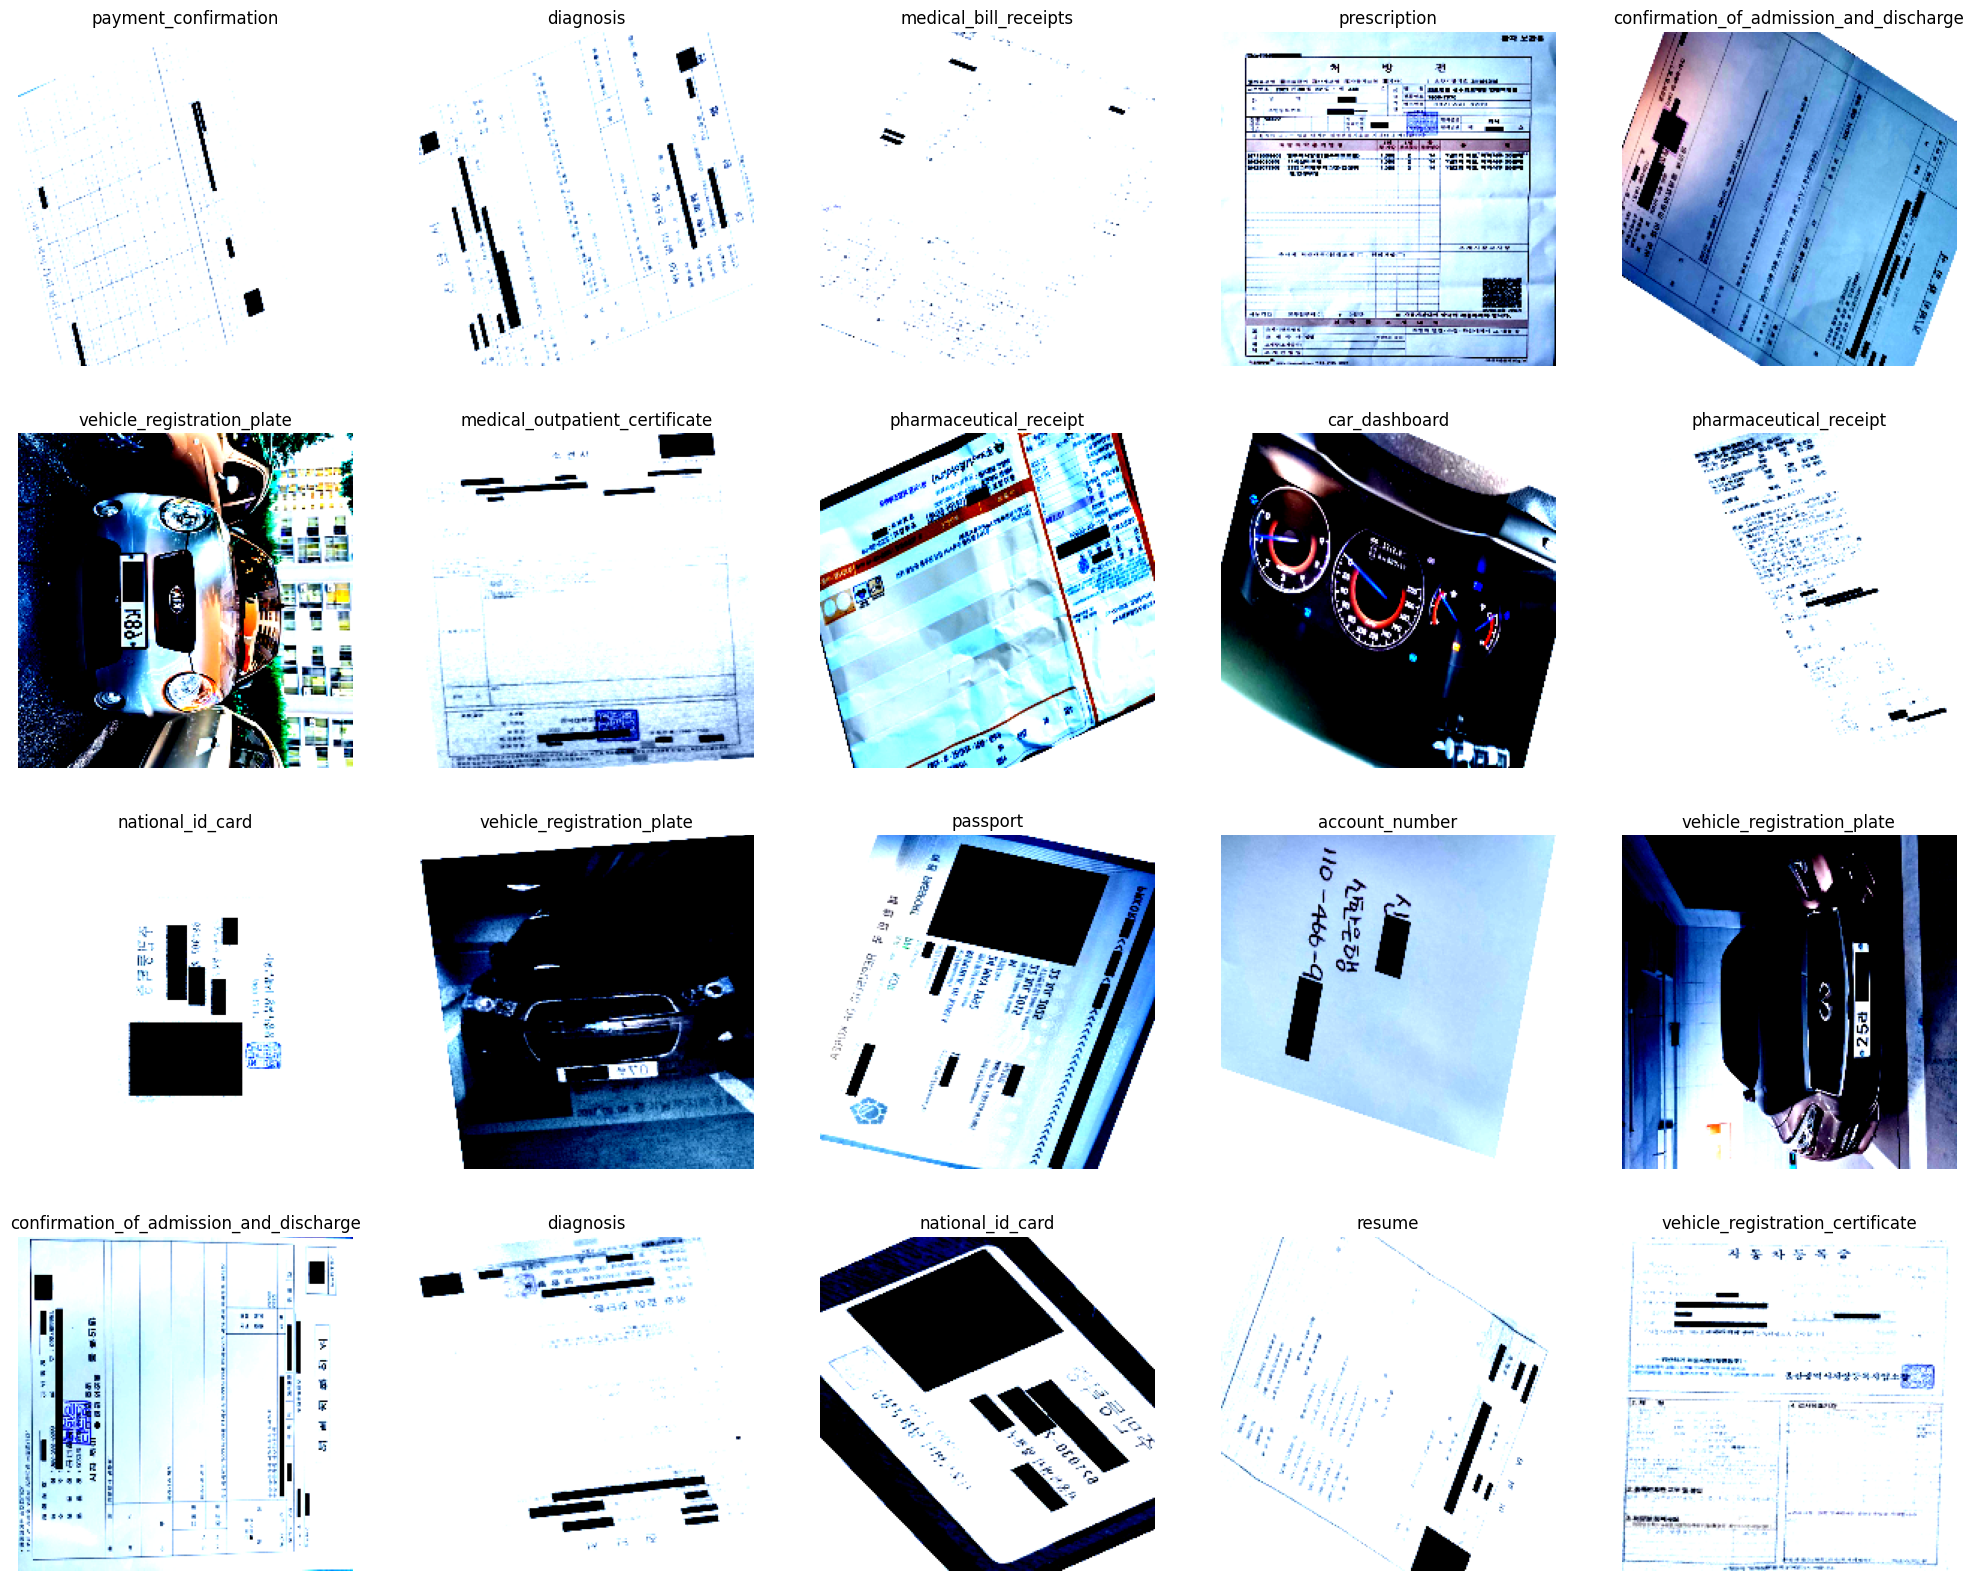

In [94]:
# 시각화할 이미지 개수
img_count = 20

# 데이터셋의 총 길이를 가져옴
dataset_len = len(test_dataset)

# 무작위로 선택된 인덱스 리스트를 생성
selected_indices = random.sample(range(dataset_len), img_count)
print("index: ", selected_indices)

# WandB에 이미지 로깅
# wandb.log({"pred_images": [wandb.Image(image, caption=label_to_class_name[label]) for i in selected_indices for image, label in [test_dataset[i]]]})

# 로컬에서 이미지 플로팅
fig, axes = plt.subplots(img_count // 5, 5, figsize=(25, 5 * (img_count // 5)))
for i, idx in enumerate(selected_indices):
    test_dataset.df = pred_df.values
    image, label = test_dataset[idx]
    row_idx = i // 5  
    col_idx = i % 5 
    
    image = np.clip(image, 0, 1)  # 값이 0보다 작으면 0, 1보다 크면 1로 클리핑
    axes[row_idx, col_idx].imshow(image.permute(1, 2, 0))
    axes[row_idx, col_idx].set_title(label_to_class_name[label])
    axes[row_idx, col_idx].axis('off')

plt.show()